In [ ]:
!pip install xgboost


In [321]:
import numpy as np
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

In [2]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [3]:
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')    


Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


In [319]:
# Extract features and labels
X = np.asarray(data.drop(columns=['Class']))
y = np.asarray(data['Class'])
# Split the dataset into training and testing sets (with stratification)
x_train, x_test, y_train, y_test = train_test_split(
   X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [ ]:
# PCA 降維
pca = PCA(n_components=20, random_state=RANDOM_SEED)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Run Isolation Forest
iso = IsolationForest(n_estimators=150, contamination=0.02, max_features=1.0, max_samples=256, random_state=RANDOM_SEED)
iso.fit(x_train_pca)
anomaly_scores_train = iso.decision_function(x_train_pca)
anomaly_labels_train = iso.predict(x_train_pca)  # -1: anomaly, 1: normal

anomaly_scores_test = iso.decision_function(x_test_pca)
anomaly_labels_test = iso.predict(x_test_pca)

# Add abnormal results to original features
x_train_with_iso = np.hstack([x_train_pca, anomaly_scores_train.reshape(-1, 1)])
x_test_with_iso = np.hstack([x_test_pca, anomaly_scores_test.reshape(-1, 1)])

# Training XGBoost classifier
xgb_model = XGBClassifier(n_estimators=150, max_depth=10, learning_rate=0.09, gamma=0.9, scale_pos_weight=60, tree_method='hist', random_state=RANDOM_SEED)
xgb_model.fit(x_train_with_iso, y_train)


# Prediction and evaluation
threshold = 0.55
y_proba = xgb_model.predict_proba(x_test_with_iso)[:, 1]
y_pred = (y_proba >= threshold).astype(int)


In [336]:
# define evaluation function
def evaluation(y_true, y_pred, model_name="Model"):
   accuracy = accuracy_score(y_true, y_pred)
   precision = precision_score(y_true, y_pred, zero_division=0)
   recall = recall_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)

   print(f'\n{model_name} Evaluation:')
   print('===' * 15)
   print('         Accuracy:', accuracy)
   print('  Precision Score:', precision)
   print('     Recall Score:', recall)
   print('         F1 Score:', f1)
   print("\nClassification Report:")
   print(classification_report(y_true, y_pred))

evaluation(y_test, y_pred, model_name="Hybrid model")


Hybrid model Evaluation:
         Accuracy: 0.9994499256814484
  Precision Score: 0.8796992481203008
     Recall Score: 0.7905405405405406
         F1 Score: 0.8327402135231317

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.79      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



Hybrid model Evaluation:
=============================================
         Accuracy: 0.9995318516437859
  Precision Score: 0.921875
     Recall Score: 0.7972972972972973
         F1 Score: 0.855072463768116

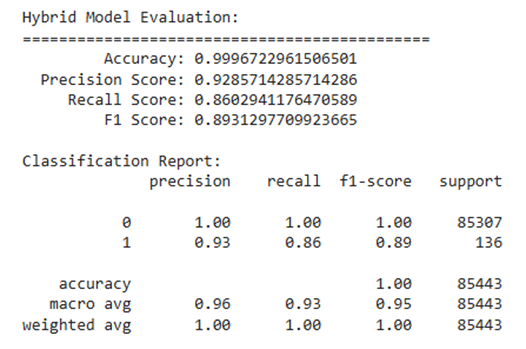